# Solution to Chess Competition

* **Competition Link**: https://www.kaggle.com/competitions/train-an-ai-to-play-chess
* **Competition Dataset**: https://www.kaggle.com/competitions/train-an-ai-to-play-chess/data
* **Competition Codes**: https://www.kaggle.com/competitions/train-an-ai-to-play-chess/code

* **Credits & Resources**:
   
   * [Chess-Rules](https://www.chess.com/learn-how-to-play-chess)
   * [Codes](https://www.kaggle.com/competitions/train-an-ai-to-play-chess/code)
   * [Youtube Video 1](https://www.youtube.com/live/l0bv8IgELfU?si=ijpiOcrPoyq-yrhW)
   * [Youtube video 2](https://www.youtube.com/live/mphW24i12_Y?si=2wVWspP6nI8lctJI)

# My DRL Projects

**Github repos(Give a star if found useful)**:

* https://github.com/hishamcse/Advanced-DRL-Renegades-Game-Bots
* https://github.com/hishamcse/DRL-Renegades-Game-Bots

**Kaggle Notebooks**:

* https://www.kaggle.com/syedjarullahhisham/code?tags=13313

# Part I : FEN & Python-Chess

In [ ]:
!pip install python-chess

# Visualize Chess

In [ ]:
import chess
board = chess.Board()
print(board)
board

### Legal Moves Initially 

In [ ]:
# use board.legal_moves to see all allowed next moves:
for move in board.legal_moves:
    print(move)

### Make A Move 

Every move is 4 characters long, and is broken up into two parts, the from square (where we're moving a piece from), and the to square (where we're moving a piece to).

This is called [Algebraic Notation](https://en.wikipedia.org/wiki/Algebraic_notation_(chess)).

For example c2c3 means "move the pawn from square c2 to square c3". We can find square c2 by looking for the column labeled c (this is also called the "c file"), and then looking for the row labeled 2 (this is also called the "2 rank"). c3 is the square directly above c2, and this a legal move for a pawn to make! Let's do it!

In [ ]:
board.push_san('c2c3')
board

In [ ]:
# Updated Legal Moves
for move in board.legal_moves:
    print(move)

In [ ]:
# Another Legal Move
board.push_san('g7g5')
board

### Game State(Win/Lose/None) 

In [ ]:
# One last thing we can look at doing is checking if we've won or lost:
print(board.outcome())

# FEN

For storing all the data on chess moves we need to to train our AI there's a better way--it's called [Forsyth–Edwards Notation](https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation), or FEN

In [ ]:
board.fen()

Let's unpack this!

The first part of FEN just shows us what's on the chess board. Every row of our chess board is separated with a slash, so we could rewrite this part as:


    rnbqkbnr
    pppppp1p
    8
    6p1
    8
    2P5
    PP1PPPPP
    RNBQKBNR


In order to keep things compact FEN doesn't show repeated spaces, it just replaces them with a number. So for example, the 8 on the 3rd line from the top means "8 blank space". We could replace all the numbers with that number of dots, just to make this clearer (this is the format python-chess gives us when we just print out the board):

In [ ]:
print(board)

The next part of FEN will always be a w or a b, showing who's turn it is. So in our FEN from above

    rnbqkbnr/pppppp1p/8/6p1/8/2P5/PP1PPPPP/RNBQKBNR w KQkq - 0 2

the **w** means it's **white's turn** to go.

After that we have a few fields for special rules we won't talk about too much: castling, en passant, and the fifty-move rule. For details, see - [Chess-Special-Rules](https://www.thesprucecrafts.com/castling-promotion-and-en-passant-611548)

- $KQkq$ means that both black and white can castle king-side and queen-side.
- '-' means there are no available en passant takes.
- 0 means there have been 0 moves since a take or a pawn advancement.

The final field is the turn counter. You can see our turn counter is at 2, which makes sense because white took 1 turn, and black took 1 turn, for a total of 2!

And that's it for FEN!

# Part II : Build Chess playing model

In [ ]:
import random
import numpy as np
import pandas as pd
import os

# Random Play

Takes FEN as input and output a random move (SAN)

In [ ]:
def play_random(fen):
    # We can create a python-chess board instance from the FEN string like this:
    board = chess.Board(fen=fen)

    # And then randomly pick a legal move:
    move = random.choice(list(board.legal_moves))

    # Now we turn our move into a string and return it!
    return str(move)

In [ ]:
# To make it easy to code up we'll always play as white.
from IPython.display import SVG, display

# Our play function accepts whatever strategy our AI is using, like play_random from above
def play_game(ai_function):
    board = chess.Board()

    while board.outcome() is None:
        # We print out the board as an SVG
        display(SVG(board._repr_svg_()))

        # If it's white's turn, we have the user play
        if board.turn == chess.WHITE:
            user_move = input('Your move: ')
            if user_move == 'quit':
                break
            # The move a user puts in isn't a valid move, we keep prompting them for a valid move
            while user_move not in [str(move) for move in board.legal_moves]:
                print('That wasn\'t a valid move. Please enter a move in Standard Algebraic Notation')
                user_move = input('Your move: ')
            board.push_san(user_move)

        # If it's black's turn, we have the AI play
        elif board.turn == chess.BLACK:
            ai_move = ai_function(board.fen())
            print(f'AI move: {ai_move}')
            board.push_san(ai_move)
    print(board.outcome())
        
play_game(play_random)

## Why RL

There are two ways we can think about building our model that come from Reinforcement Learning:

*     A Policy
*     A Value Function
    
In RL **a policy** is a function that goes from "world states" (everything our AI knows about the world) to actions. It's a pretty natural fit for chess, where our "world state" is our FEN string (the board) and actions are the legal chess moves our AI could make.

There's one catch: while our world state is relatively simple, there are a lot of potential moves our model needs to be able to put out. There are 64 possible starting square and 64 possible ending squares--so that's technically $64^2 = 4096$ possible moves.

Whats more, on any given turn, most of those 4096 possible turns won't even be legal moves, so our model will have to try real hard just to output a move it's allowed to make. But we already know what moves are legal, python-chess gives that to us for free!

So another way we can think about this is to implement a value function. **A value function** basically just tells our AI how good a certain state of the world is.

For example, a board where we have all our pieces, and our opponent only has a king and 1 pawn is great for us, and our value function would put out a really high number. If this was reversed, we'd be doing terribly, and our value function would put out a really low number.

So instead of training our model to take in the board state and output a move (this would be treating our model as a policy) we could train our model to take in the board state and output a value (treating our model as a value function). Then we can just loop through all possible moves, rate all the possible board states after making those moves, and then pick the move with the highest board state.

# Prepare Data

Before we feed our input into a neural network for training, we need to turn it all into numbers.

Once we replace the numbers with periods, our FEN notation is pretty close--it's an 8x8 grid of characters.

    r n b q k b n r
    p p p p p p p p
    . . . . . . . .
    . . . . . . . .
    . . . . . . . .
    . . . . . . . .
    P P P P P P P P
    R N B Q K B N R
    
One common strategy in machine learning is to **one hot encode** our input. There are **13** different characters on our board right now: **6 upper case (white)** pieces, **6 lower case (black)** pieces, and . for **empty** spaces. So we could one-hot encode our input with a list of 13 elements, one for each piece type:

This could be the one hot encoding for a **white Bishop**:

     r n b q k p R N B Q K P .
    [0 0 0 0 0 0 0 0 1 0 0 0 0]
    
And this could be the one hot encoding for an **empty space**:

     r n b q k p R N B Q K P .
    [0 0 0 0 0 0 0 0 0 0 0 0 1]
    
Notice in both examples we only have 1 1, and all the rest are zeros.

## Encode Chess Board 

In [ ]:
def one_hot_encode_piece(piece):
    pieces = list('rnbqkpRNBQKP.')
    arr = np.zeros(len(pieces))
    piece_to_index = {p: i for i, p in enumerate(pieces)}
    index = piece_to_index[piece]
    arr[index] = 1
    return arr

# Let's test on a black bishop
one_hot_encode_piece('b')

In [ ]:
def encode_board(board):
    # first lets turn the board into a string
    board_str = str(board)
    # then lets remove all the spaces
    board_str = board_str.replace(' ', '')
    board_list = []
    for row in board_str.split('\n'):
        row_list = []
        for piece in row:
            row_list.append(one_hot_encode_piece(piece))
        board_list.append(row_list)
    return np.array(board_list)

# Let's test on the starting board
encode_board(chess.Board())

Encode the FEN representation of chess board

In [ ]:
def encode_fen_string(fen_str):
    board = chess.Board(fen=fen_str)
    return encode_board(board)

## Preprocess Training Data 

In [98]:
train_df = pd.read_csv('/kaggle/input/train-an-ai-to-play-chess/train.csv', index_col='id')
train_df.head()

# We'll also grab the last 10000 examples as a validation set
val_df = train_df[-10000:]
val_df.head()

,board,black_score,best_move
id,,,
81216,8/5r2/3K4/8/4k3/8/8/8 w - - 20 138,455.0,d6c6
38079,6k1/pp5p/8/3p1p2/3Rb1p1/bP1NP1P1/P1r2P1P/3R2K1...,-246.0,d4a4
62373,8/3B4/3b4/p7/2K5/8/1k6/8 w - - 13 62,0.0,d7a4
45874,8/1r6/2k2p2/p2b1p2/2p2P2/1P2K3/P1RN2P1/8 w - -...,-109.0,d2c4
71079,8/8/5K2/2k3n1/8/8/2B5/8 w - - 49 80,0.0,c2b3


In [99]:
# We'll use all except last 10000 examples as a training set
train_df = train_df[:-10000]
train_df.head()

,board,black_score,best_move
id,,,
80091,6R1/8/5K2/8/5k2/8/8/2r5 w - - 89 118,0.0,g8d8
18578,r1bn1rk1/1p2b1p1/1q2p2p/p2p1p1n/P2P3P/2PB1N2/1...,-131.0,f3e5
11580,r2qkb1r/2p2pp1/p1n2nP1/1p1p3p/P7/1Q5b/1PP1PPB1...,-490.0,g6f7
72805,8/4kp2/R6p/8/4K3/8/8/8 b - - 7 85,-574.0,h6h5
74310,8/8/k7/4R3/8/6K1/8/1r6 w - - 99 90,0.0,e5e6


In [100]:
X_train = np.stack(train_df['board'].apply(encode_fen_string))
y_train = train_df['black_score']

In [101]:
X_val = np.stack(val_df['board'].apply(encode_fen_string))
y_val = val_df['black_score']

# Train & Evaluate RL Model

In [202]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import callbacks

# With the Keras Sequential model we can stack neural network layers together
model = Sequential([
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(1),
])

model.compile(
    optimizer='adam',
    loss='mean_squared_error')

In [159]:
checkpoint_path = "training_1/chess.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# # if already trained(so trained from last checkpoint)
# model.load_weights(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1) 

In [160]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[cp_callback])

Epoch 1/100
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153008.4062
Epoch 1: val_loss improved from inf to 141444.15625, saving model to training_1/chess.weights.h5
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 153006.1719 - val_loss: 141444.1562
Epoch 2/100
1506/1525 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 135611.9531
Epoch 2: val_loss improved from 141444.15625 to 129390.79688, saving model to training_1/chess.weights.h5
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 135546.4844 - val_loss: 129390.7969
Epoch 3/100
1503/1525 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 120667.4922
Epoch 3: val_loss improved from 129390.79688 to 123570.98438, saving model to training_1/chess.weights.h5
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 120684.2812 - val_loss: 123570.9844
Epoch 4/100
1494/1525 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 116821.1094
Epoch 4: val_loss improved from 123570.98438 to 120418.25000, saving model to training_1/chess.weights.h5
1525/1525 ━━━━━━━━━━━━━━

## Visualize Trained Model 

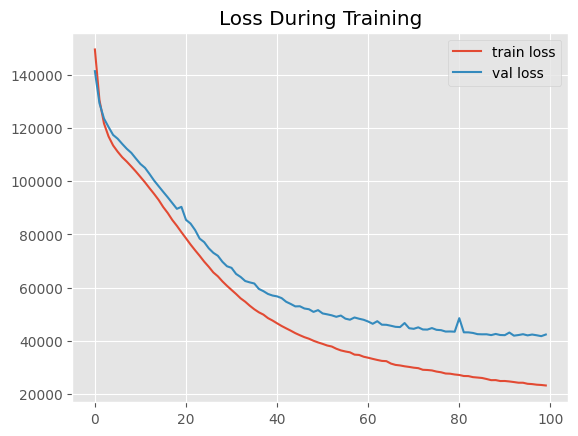

In [161]:
import matplotlib.pyplot as plt

# Lets plot the history of our training session to see how things progressed over time
plt.style.use('ggplot')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss During Training')
plt.show()

## Value Function to Create Policy 

So we have a decent value function now! We show it a board state, and it tells us how good that board is for black.

But if our AI is going to play chess, we need a way to turn that board state into a decision, or in other words, we need to use our value function to create a policy.

One simple way we can do this is to look at all the legal moves we can make, test our making each of them, and pick whatever move gives us the highest value to the resultant board state. Let's code that up!

In [87]:
# same as the youtube implementation
def play_nn_video(fen, show_move_evaluations=False, player='b'):
    # We can create a python-chess board instance from the FEN string like this:
    board = chess.Board(fen=fen)

    # And then evaluate all legal moves
    moves = []
    input_vectors = []
    for move in board.legal_moves:
        # For each move, we'll make a copy of the board and try that move out
        candidate_board = board.copy()
        candidate_board.push(move)
        moves.append(move)
        input_vector = encode_board(str(candidate_board))
        input_vectors.append(input_vector)
    
    input_vectors = np.stack(input_vectors)
    # This is where our model gets to shine! It tells us how good the resultant score board is for black:
    scores = model.predict(input_vectors, verbose=0)
    
    if player == 'b':
        idx_best = np.argmax(scores)
    else:
        idx_best = np.argmax(-scores)

    if show_move_evaluations:
        print(zip(moves, scores))
    
    # By default sorting our moves will put the lowest scores at the top.
    # This would give us the right answer if we were playing as white,
    # but if we're playing as black we want to reverse things (then grab the first move):
    best_move = moves[idx_best]

    # Now we turn our move into a string, return it and call it a day!
    return str(best_move)

In [88]:
def play_nn(fen, show_move_evaluations=False, player='b'):
    # We can create a python-chess board instance from the FEN string like this:
    board = chess.Board(fen=fen)

    # And then evaluate all legal moves
    moves = []
    for move in board.legal_moves:
        # For each move, we'll make a copy of the board and try that move out
        candidate_board = board.copy()
        candidate_board.push(move)
        input_vector = encode_board(str(candidate_board))
        
        # This is where our model gets to shine! It tells us how good the resultant score board is for black:
        score = model.predict(np.expand_dims(input_vector, axis=0), verbose=0)[0][0]
        moves.append((score, move))
        if show_move_evaluations:
            print(f'{move}: {score}')
    
    # By default sorting our moves will put the lowest scores at the top.
    # This would give us the right answer if we were playing as white,
    # but if we're playing as black we want to reverse things (then grab the first move):
    best_move = sorted(moves, reverse=player=='b')[0][1]

    # Now we turn our move into a string, return it and call it a day!
    return str(best_move)

In [ ]:
# Now that we have a policy, we can play against it!

play_game(play_nn)

# Part III : Make Prediction & Submit

### Import Test Set 

In [162]:
test_df = pd.read_csv('/kaggle/input/train-an-ai-to-play-chess/test.csv')
test_df.head()

,id,board
0,7937,r1bqk2r/pp2bpp1/2n1pn1p/2pp4/3P1B2/2P1PN2/PP1N...
1,20035,2r2k1r/pp2pp1p/1q3npb/1B1N4/8/P4Q1P/1P3PP1/R2R...
2,71263,3b4/8/5k2/5p2/8/4K3/8/5B2 b - - 2 80
3,61997,5k2/R7/3r3p/2PP2pP/5pb1/P1K5/6B1/8 w - - 1 61
4,26510,r3r1k1/pb3p1p/1p1q2p1/3P1p2/3Q1P2/5N2/PP4PP/3R...


### Predict Moves

Making all of our predictions happens in this one line! We're basically saying "run play_nn on all the boards in the test_df, and then keep the results as best_move". Because this involves running our model a _ton_ this step will take a while.

In [163]:
test_df['best_move'] = test_df['board'].apply(play_nn_video)
test_df['best_move']

0      c5d4
1      d5c7
2      d8e7
3      a7f7
4      e8e1
       ... 
195    a5d5
196    h7h6
197    a8f8
198    h5d5
199    h8g8
Name: best_move, Length: 200, dtype: object

## Submission 

In [ ]:
sample_submission = pd.read_csv('/kaggle/input/train-an-ai-to-play-chess/sample_submission.csv', index_col='id')
sample_submission.head()

In [164]:
submission = test_df[['id', 'best_move']]
submission.head()

,id,best_move
0,7937,c5d4
1,20035,d5c7
2,71263,d8e7
3,61997,a7f7
4,26510,e8e1


In [165]:
submission.to_csv('submission.csv', index=False)

# Part IV : Ensemble Models

So far we've always used a single neural network to make all of our moves. This has worked okay, but it doesn't take advantage of the fact that there are a lot of different skills used at different points in a chess game.

For example, sometimes we'll break up a chess game into 3 parts:

* The opening
* The midgame
* The endgame

Some chess players might have lots of powerful openings memorized, but struggle to deliver checkmate in the endgame. Personally, I have a decent edgame (relative to my whole game being terrible) but my midgame is rough.

This fact that chess can be broken into different kinds of problems means that building an ensemble model could work well here. The general idea behind ensemble models is to create multpile models that are experts in different parts of your dataset, then use them together to create your final predictions.

In order to tell **what phase of the game we're in**, we can count the total "points of material" on the board. If there are lots of pieces left of the board, we're probably in the opening, and if we only have a few left, we're probably near the endgame.

## Material Counter Version 1 

In [276]:
def count_material(fen):
    total_material = 0
    material_dict = {
        'p': 1,
        'b': 3,
        'n': 3,
        'r': 5,
        'q': 9
    }
    
    for char in fen.lower():
        if char in material_dict:
            total_material += material_dict[char]
            
    return total_material

In [277]:
train_df = pd.read_csv('/kaggle/input/train-an-ai-to-play-chess/train.csv', index_col='id')
train_df['total_material'] = train_df['board'].apply(count_material)

### Plot Histogram 

(array([ 5973., 11022.,  8581.,  6077.,  4980.,  4993.,  4471.,  3682.,
         2834.,  6172.]),
 array([  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101.]),
 <BarContainer object of 10 artists>)

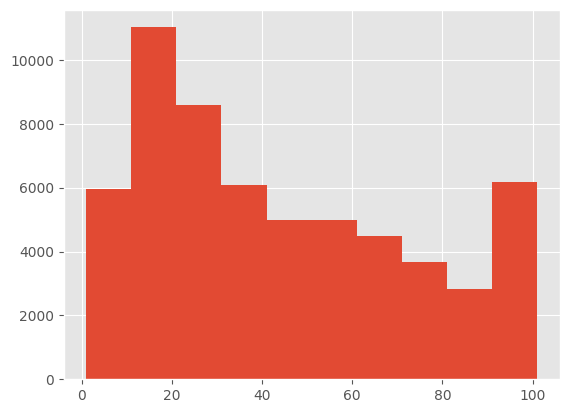

In [278]:
import matplotlib.pyplot as plt

plt.hist(train_df['total_material'])

## Material Counter Encoder 

https://www.kaggle.com/code/paritoshdahiya/ghw-chess-ai-custom-encoding/notebook

If you want modified encoding according to this notebook then make this true. This is not one-hot encoding. 

In [279]:
adv_enc = True

In [280]:
if adv_enc:
    def encode_board(board):
        # first lets turn the board into a string
        board_str = str(board)
        # then lets remove all the spaces
        material_dict = {
            'p': -1,
            'b': -3.5,
            'n': -3,
            'r': -5,
            'q': -9,
            'k': -4,
            'K': 4,
            '.': 0,
            'P': 1,
            'B': 3.5,
            'N': 3,
            'R': 5,
            'Q': 9,
        }
        board_str = board_str.replace(' ', '')
        board_list = []
        for row in board_str.split('\n'):
            row_list = []
            for piece in row:
                # print(piece)
                row_list.append(material_dict.get(piece))
            board_list.append(row_list)
        return np.array(board_list)

In [281]:
if adv_enc:
    def encode_fen_string(fen_str):
        board = chess.Board(fen=fen_str)
        return encode_board(board)

In [282]:
if adv_enc:
    X_train = np.stack(train_df['board'].apply(encode_fen_string))
    y_train = train_df['black_score']
    X_val = np.stack(val_df['board'].apply(encode_fen_string))
    y_val = val_df['black_score']

This histogram of all our boards total material is interesting!
We have a lot of boards with relatively few points, and only a few with more than 70.
We see an interesting spike around 100, which is probably due to promotion, when a pawn reaches the end of board and can turn into a queen. Promotion usually happens near the end of a game, so our hueristic isn't perfect (sometimes having a lot of points of material left means you're in the endgame).
But it should still work well enough!
Let's say:
* **Opening**: > 60 points of material
* **Midgame**: between 30 and 60 points of material
* **Endgame**: less than 30 points of material

The exact cutoff doesn't matter; the important part is that we're breaking our hard problem (all of chess) in to easier subproblems we can easily identify.

## Split Training Data 

In [283]:
endgame_df = train_df[train_df['total_material'] < 30]
midgame_df = train_df[(30 <= train_df['total_material']) & (train_df['total_material'] <= 65)]
opening_df = train_df[65 < train_df['total_material']]

# Train & Evaluate Model

In [284]:
def gen_train_eval_model(data_to_train_on, idx):
    val_df = data_to_train_on[-5000:]
    train_df = data_to_train_on[:-5000]
    
    X_train = np.stack(train_df['board'].apply(encode_fen_string))
    y_train = train_df['black_score']

    X_val = np.stack(val_df['board'].apply(encode_fen_string))
    y_val = val_df['black_score']
    
    model = Sequential([
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1),
    ])
    
    model.compile(
        optimizer='adam',
        loss='mean_squared_error')
    
    checkpoint_path = f"training_1/chess_{idx}.weights.h5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

    model_checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     save_best_only=True,
                                                     verbose=1) 

    history = model.fit(
        X_train,
        y_train,
        epochs=300,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint])

    import matplotlib.pyplot as plt

    # Lets plot the history of our training session to see how things progressed over time
    plt.style.use('ggplot')
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.title('Loss During Training')
    plt.show()
    
    return model

Epoch 1/300
630/630 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 185413.6094
Epoch 1: val_loss improved from inf to 178493.31250, saving model to training_1/chess_1.weights.h5
630/630 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 185401.8125 - val_loss: 178493.3125
Epoch 2/300
613/630 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 162306.9531
Epoch 2: val_loss improved from 178493.31250 to 165183.18750, saving model to training_1/chess_1.weights.h5
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 162293.7969 - val_loss: 165183.1875
Epoch 3/300
627/630 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 155298.4688
Epoch 3: val_loss improved from 165183.18750 to 158453.56250, saving model to training_1/chess_1.weights.h5
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 155272.9375 - val_loss: 158453.5625
Epoch 4/300
603/630 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 137089.7344
Epoch 4: val_loss improved from 158453.56250 to 152540.68750, saving model to training_1/chess_1.weights.h5
630/630 ━━━━━━━━━━━━━━━━━━━━ 1

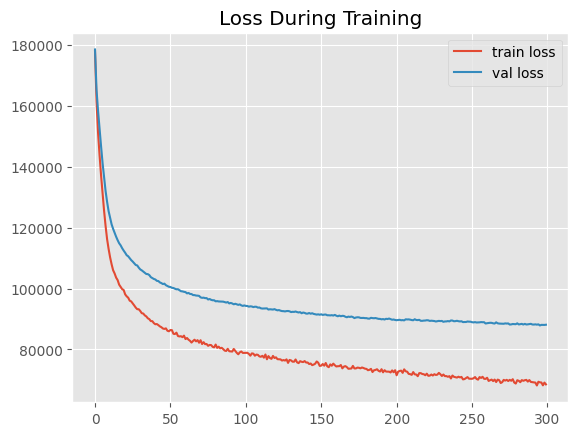

In [285]:
endgame_model = gen_train_eval_model(endgame_df, 1)

Epoch 1/300
424/424 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 167143.6875
Epoch 1: val_loss improved from inf to 162371.71875, saving model to training_1/chess_2.weights.h5
424/424 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 167146.9219 - val_loss: 162371.7188
Epoch 2/300
401/424 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160441.6250
Epoch 2: val_loss improved from 162371.71875 to 154369.10938, saving model to training_1/chess_2.weights.h5
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 160376.6250 - val_loss: 154369.1094
Epoch 3/300
393/424 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160547.7500
Epoch 3: val_loss improved from 154369.10938 to 150732.06250, saving model to training_1/chess_2.weights.h5
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 159991.4219 - val_loss: 150732.0625
Epoch 4/300
400/424 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 153815.1094
Epoch 4: val_loss improved from 150732.06250 to 147581.89062, saving model to training_1/chess_2.weights.h5
424/424 ━━━━━━━━━━━━━━━━━━━━ 1

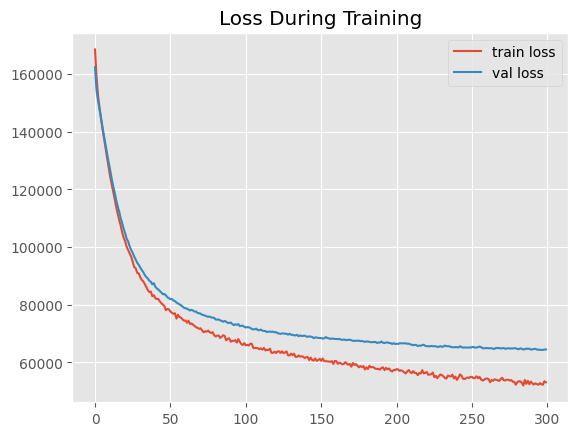

In [286]:
midgame_model = gen_train_eval_model(midgame_df, 2)

Epoch 1/300
316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 121951.7266
Epoch 1: val_loss improved from inf to 115007.42188, saving model to training_1/chess_3.weights.h5
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 121951.8594 - val_loss: 115007.4219
Epoch 2/300
312/316 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 119866.9531
Epoch 2: val_loss improved from 115007.42188 to 107075.66406, saving model to training_1/chess_3.weights.h5
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 119797.7812 - val_loss: 107075.6641
Epoch 3/300
293/316 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 110940.7344
Epoch 3: val_loss improved from 107075.66406 to 102106.47656, saving model to training_1/chess_3.weights.h5
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 110836.4375 - val_loss: 102106.4766
Epoch 4/300
305/316 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 107698.2734
Epoch 4: val_loss improved from 102106.47656 to 99704.14062, saving model to training_1/chess_3.weights.h5
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s

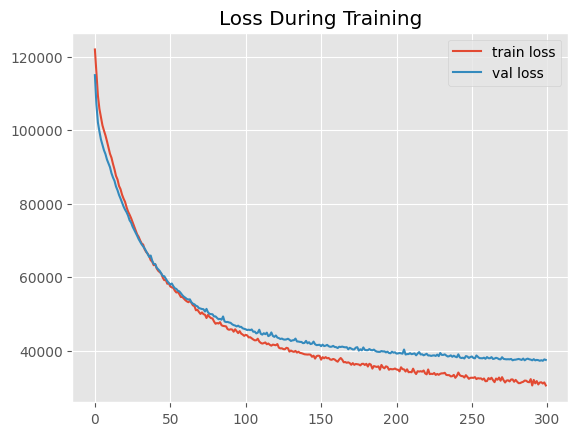

In [287]:
opening_model = gen_train_eval_model(opening_df, 3)

# Updated Policy Function

In [288]:
def play_nn_new(fen, show_move_evaluations=False):
    # We can create a python-chess board instance from the FEN string like this:
    board = chess.Board(fen=fen)

    material = count_material(fen)
    if material < 30:
        model = endgame_model
    elif material <= 65:
        model = midgame_model
    else:
        model = opening_model
    
    moves = []
    input_vectors = []
    for move in board.legal_moves:
        # For each move, we'll make a copy of the board and try that move out
        candidate_board = board.copy()
        candidate_board.push(move)
        moves.append(move)
        input_vectors.append(encode_board(str(candidate_board)))
    
    input_vectors = np.stack(input_vectors)
    # This is where our model gets to shine! It tells us how good the resultant score board is for black:
    scores = model.predict(input_vectors, verbose=0)
    # argmax gives us the index of the highest scoring move
    if board.turn == chess.BLACK:
        index_of_best_move = np.argmax(scores)
    else:
        # If we're playing as white, we want black's score to be as small as possible, so we take argmax of the negative of our array
        index_of_best_move = np.argmax(-scores)

    if show_move_evaluations:
        print(zip(moves, scores))
        
    best_move = moves[index_of_best_move]

    # Now we turn our move into a string, return it and call it a day!
    return str(best_move)

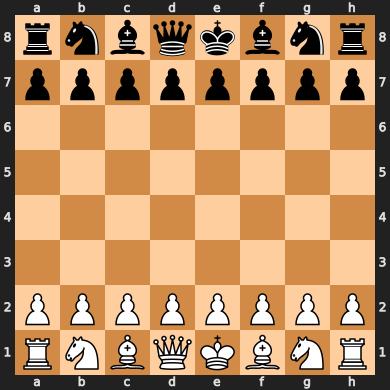

Your move:  c2c4


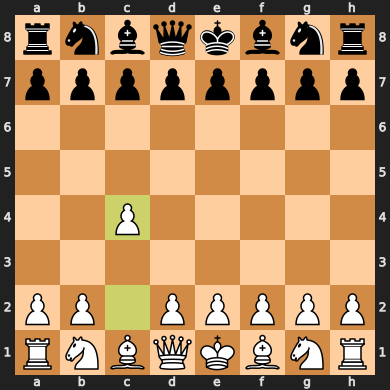

AI move: b8c6


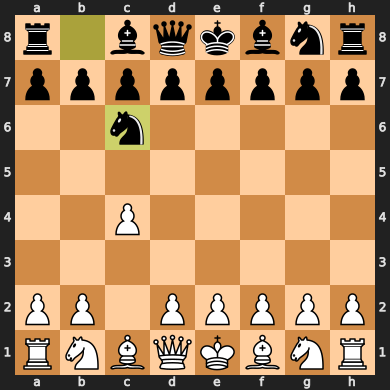

KeyboardInterrupt: Interrupted by user

In [182]:
play_game(play_nn_new)

# Predict & Submit Ensembled Model

In [289]:
test_df = pd.read_csv('/kaggle/input/train-an-ai-to-play-chess/test.csv')
test_df.head()

,id,board
0,7937,r1bqk2r/pp2bpp1/2n1pn1p/2pp4/3P1B2/2P1PN2/PP1N...
1,20035,2r2k1r/pp2pp1p/1q3npb/1B1N4/8/P4Q1P/1P3PP1/R2R...
2,71263,3b4/8/5k2/5p2/8/4K3/8/5B2 b - - 2 80
3,61997,5k2/R7/3r3p/2PP2pP/5pb1/P1K5/6B1/8 w - - 1 61
4,26510,r3r1k1/pb3p1p/1p1q2p1/3P1p2/3Q1P2/5N2/PP4PP/3R...


In [290]:
test_df['best_move'] = test_df['board'].apply(play_nn_new)
test_df['best_move']

0       f6g4
1       d5b6
2       f6g7
3       c5d6
4       d6d7
       ...  
195     b4b2
196     c5d5
197    c7c8q
198     h2g1
199     d8d2
Name: best_move, Length: 200, dtype: object

In [291]:
submission = test_df[['id', 'best_move']]
submission.head()

,id,best_move
0,7937,f6g4
1,20035,d5b6
2,71263,f6g7
3,61997,c5d6
4,26510,d6d7


In [292]:
submission.to_csv('submission.csv', index=False)